In [1]:
# 1. 각각의 Client로컬 학습 모델의 Receptive Field를 계산한다.
import os
import sys
import pathlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import torch

def load_all_models(path):
    folder_path = path
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pth"):
                file_list.append(pathlib.Path(root) / file)
    # sorting file_list
    file_list.sort()
    # dirnames
    model_state_dict = {}
    for file in file_list:
        print("file_name : ", file)
        # get index from file name ex. "client_0_best_models" > "0", "test 1" > "1"
        if 'global' in file.parent.name:
            model_state_dict[-1] = torch.load(file) 
            print("file.parent.name: ", file.parent.name)
        else:
            index = int(file.parent.name.split('_')[1])
            model_state_dict[index] = torch.load(file)
            print("file.parent.name: ", file.parent.name, "index: ", index)
    return model_state_dict

model_state_dict = load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227")

model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/59831/global/model_round15_acc83.90_loss0.69.pth")

file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227/client_0_best_models/model_round13_acc82.55_loss0.93.pth
file.parent.name:  client_0_best_models index:  0
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227/client_1_best_models/model_round18_acc93.49_loss0.23.pth
file.parent.name:  client_1_best_models index:  1
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227/client_2_best_models/model_round20_acc82.22_loss0.83.pth
file.parent.name:  client_2_best_models index:  2
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227/client_3_best_models/model_round3_acc90.44_loss0.53.pth
file.parent.name:  client_3_best_models index:  3
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227/client_4_best_models/model_round16_acc90.34_loss0.32.pth
file.parent.name:  client_4_best_models index:  4
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227/client_5_best_models/model_r

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 44.49 GiB total capacity; 131.73 MiB already allocated; 15.12 MiB free; 138.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import models
import utils
import datasets
import config
utils.set_seed(42)

In [ ]:
args = config.init_args(server=True, ipykernel=True)

args.excluded_heads []


In [ ]:
args.batch_size = 20
datasetpartition = datasets.PascalVocSegmentationPartition(args)
train_dataset, valid_dataset = datasetpartition.load_partition(-1)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader = valid_loader

malicious clients: []
dirichlet
1464 1449


In [ ]:
network = models.get_network("segformer", 21, pretrained=True)

Loading pretrained model...


In [ ]:
img, lab = next(iter(test_loader))

In [ ]:
img.shape, lab.shape

(torch.Size([20, 3, 224, 224]), torch.Size([20, 56, 56]))

In [ ]:
# 1) draw orginal image
# 2) draw predicted image with ground truth boundary for each client
img = img.to("cuda")
img_index = [0,2,6,7,9,16]
img = img[img_index]
lab = lab[img_index]
network = network.to("cuda")
preds = {}
for key in model_state_dict.keys():
    network.load_state_dict(model_state_dict[key])
    preds[key] = network(img).detach().cpu().numpy()
img = img.detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

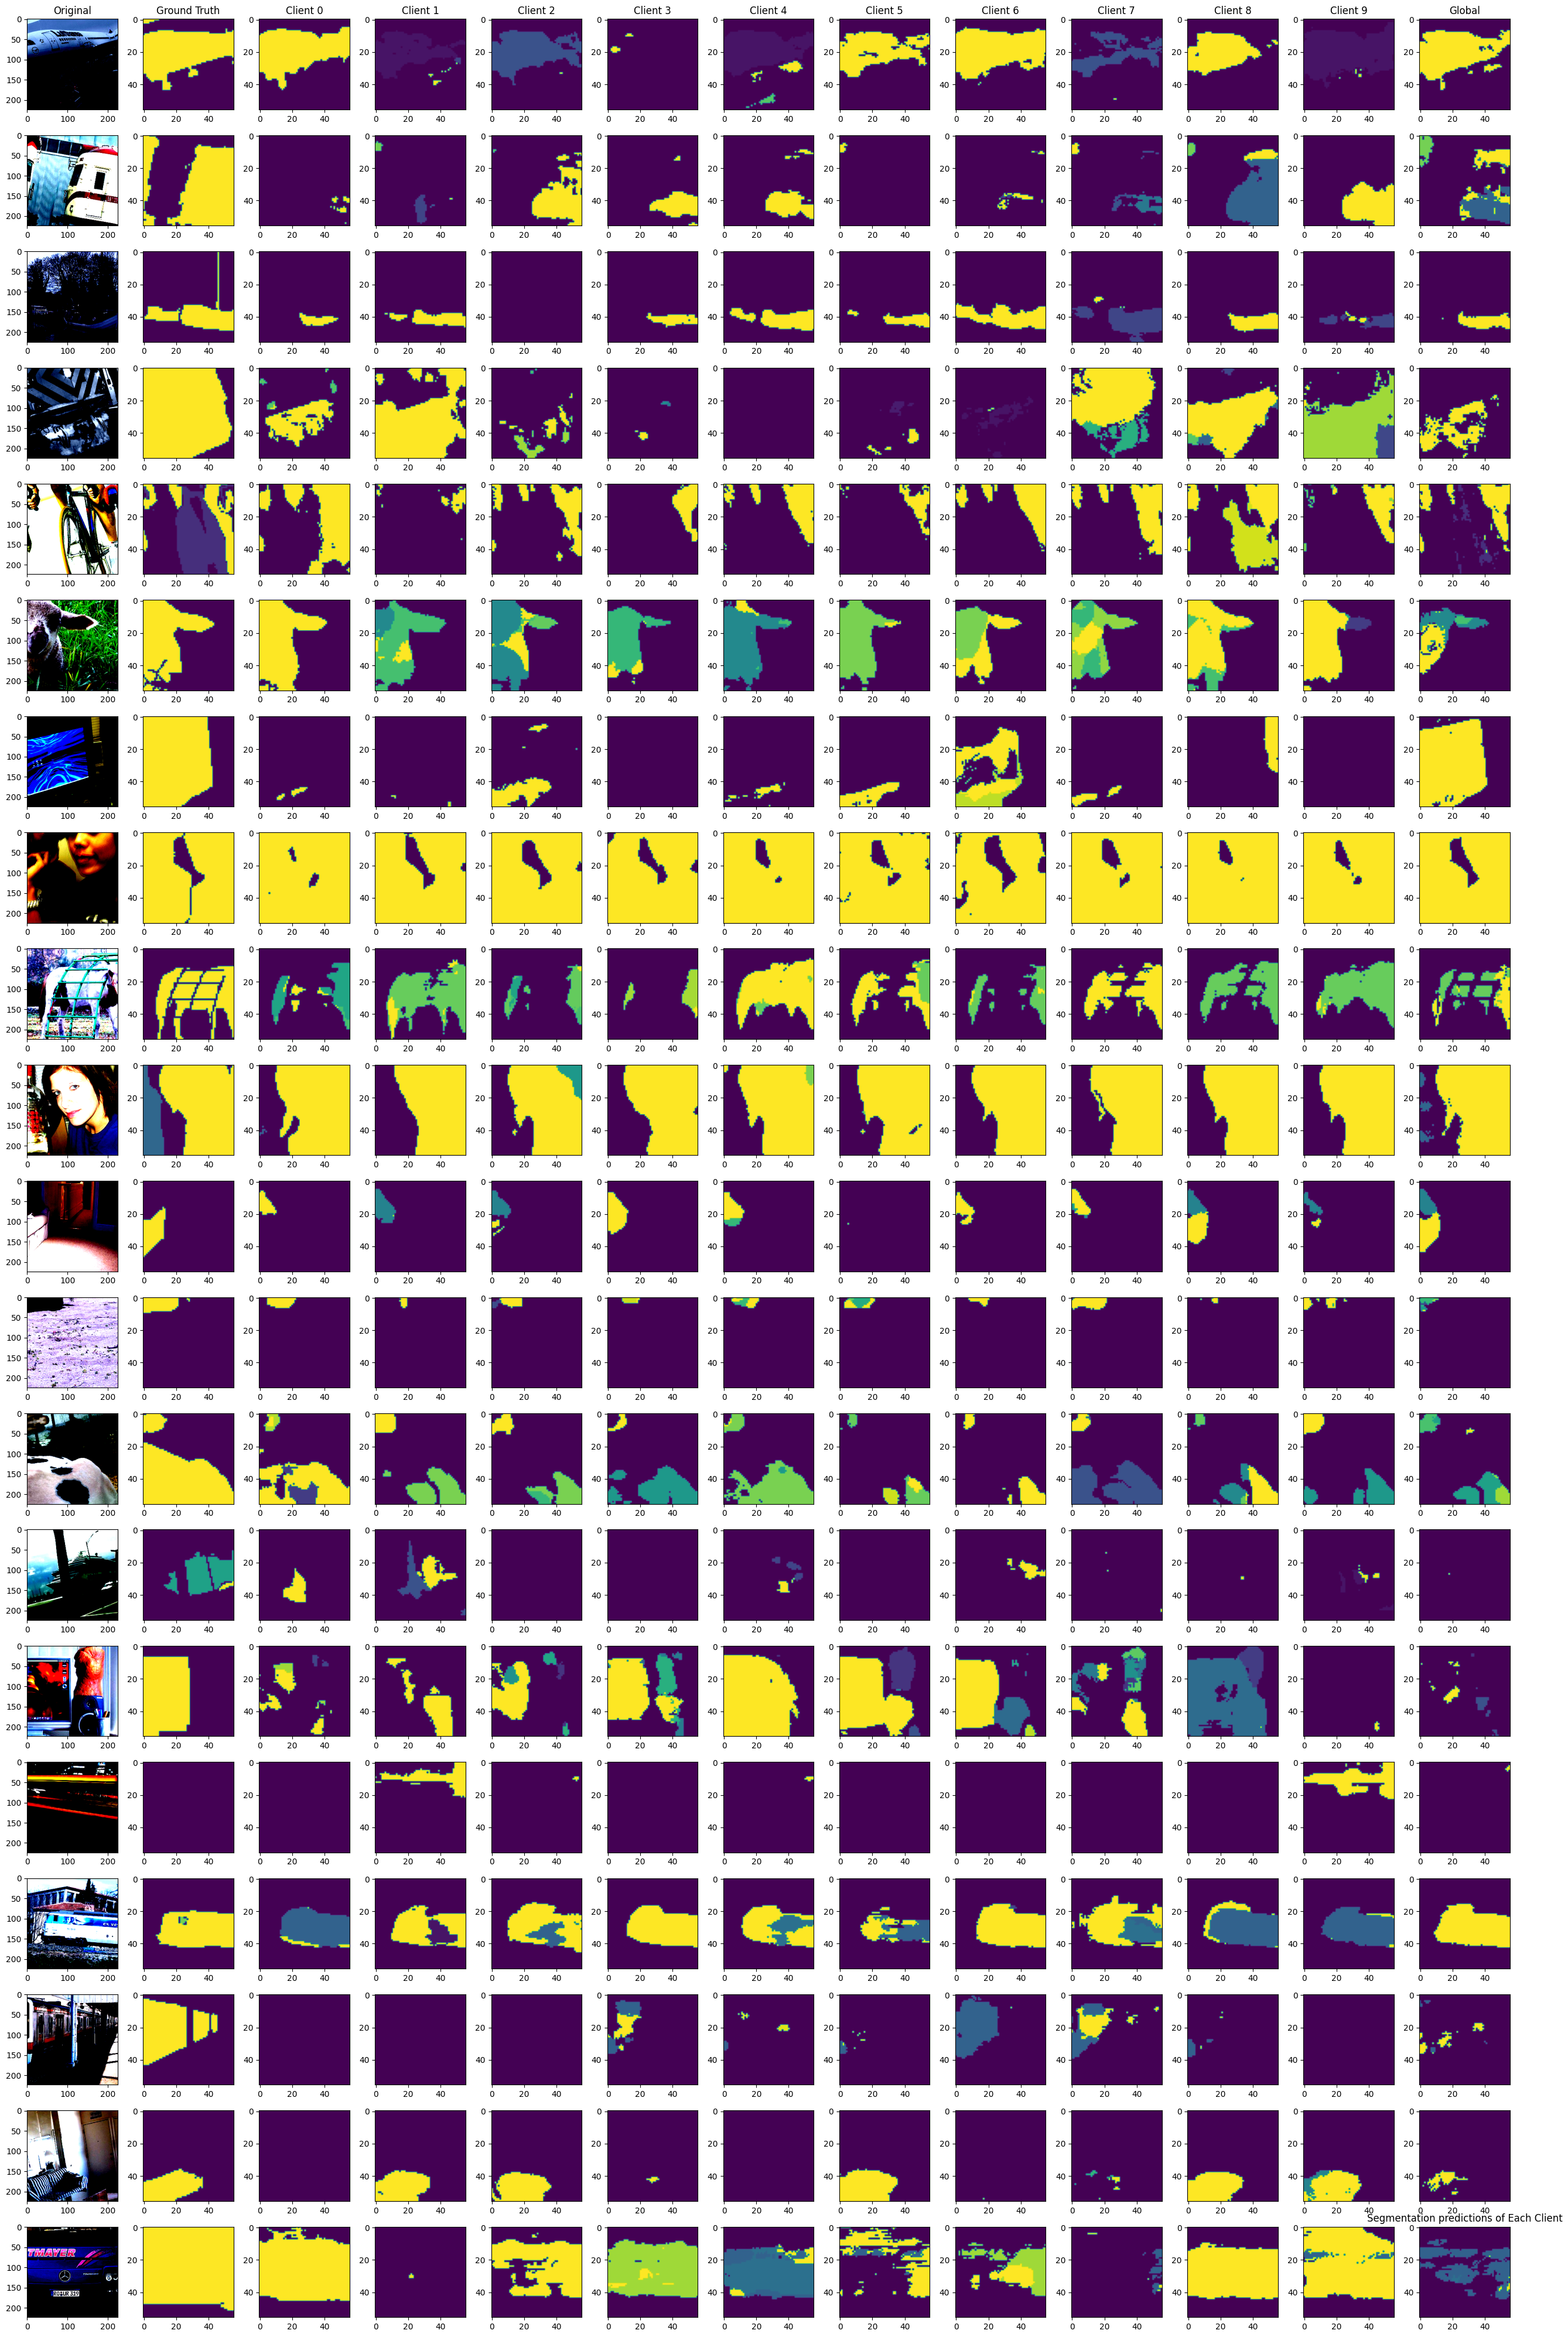

In [ ]:
n_row = len(img)
n_col = len(model_state_dict.keys()) + 2 # 1 for original image, 1 for ground truth

fig = plt.figure(figsize=(n_col*2, n_row*2))
for i in range(n_row):
    plt.subplot(n_row, n_col, i*n_col+1)
    if i == 0:
        plt.title("Original")b
    plt.imshow(img[i].permute(1, 2, 0))
    plt.subplot(n_row, n_col, i*n_col+2)
    if i == 0:
        plt.title("Ground Truth")
    plt.imshow(lab[i])
    for j, key in enumerate(model_state_dict.keys()):
        plt.subplot(n_row, n_col, i*n_col+3+j)
        if i == 0:
            plt.title(f"Client {key}" if key != -1 else "Global")
        plt.imshow(np.argmax(preds[key][i], axis=0))

fig.tight_layout()
plt.title("Segmentation predictions of Each Client")
plt.savefig("figure4.png", dpi=300)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_row = len(img)
n_col = len(model_state_dict.keys()) + 2  # 1 for original image, 1 for ground truth
pascal_voc_labels = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

def get_label_text(label):
    unique_labels = np.unique(label)
    num_instances = len(unique_labels)
    label_text = [pascal_voc_labels[l] for l in unique_labels if l != 0]
    label_text = ", ".join(label_text)
    return label_text

fig = plt.figure(figsize=(n_col*2, n_row*2))
fig.suptitle("Segmentation predictions of Each Client", fontsize=16)

for i in range(n_row):
    plt.subplot(n_row, n_col, i*n_col+1)
    if i == 0:
        plt.title("Original")
    plt.imshow(img[i].permute(1, 2, 0))
    plt.axis('off')
    label_text = get_label_text(lab[i])
    print(label_text)
    plt.ylabel(get_label_text(lab[i]), fontsize=12, rotation=0, labelpad=40)  # y축 레이블 추가
    
    plt.subplot(n_row, n_col, i*n_col+2)
    if i == 0:
        plt.title("Ground Truth")
    plt.imshow(lab[i])
    plt.xticks([])
    plt.yticks([])
    
    for j, key in enumerate(model_state_dict.keys()):
        plt.subplot(n_row, n_col, i*n_col+3+j)
        
        if i == 0:
            plt.title(f"Client {key}" if key != -1 else "Global")
        plt.imshow(np.argmax(preds[key][i], axis=0))
        plt.axis('off')

fig.tight_layout()
#figure title
plt.savefig("figure4.png", dpi=300)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


aeroplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


boat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bicycle, person


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sheep
